In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Generate data
Data are drawn from a mixture of four Gaussians with fixed means and variances

In [13]:
np.random.seed(42)

In [14]:
def generate_data(n=20):
    
    # cluster centers
    centers = np.array([
        [1, 1],
        [5, 1],
        [1, 5],
        [5, 5]
    ])
    
    X = []
    for center in centers:
        xs = center + np.random.randn(20, 2) * 0.4
        X.append(xs)
    X = np.vstack(X)
    
    y = np.concatenate([
        np.zeros(n),
        np.ones(n),
        np.ones(n),
        np.zeros(n),
    ])
    
    return X, y
    

In [15]:
X, y = generate_data()

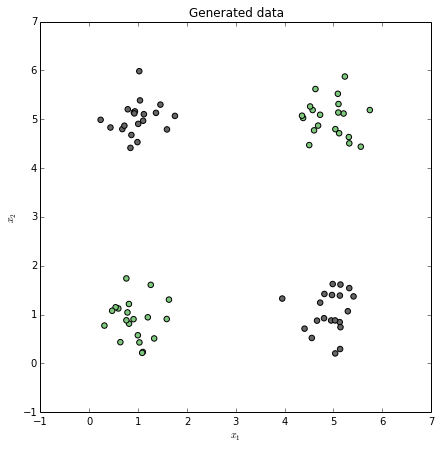

In [16]:
figure(figsize=(7,7))
scatter(X[:,0], X[:,1], c=y, cmap=cm.Accent, s=30)
title('Generated data')
xlabel('$x_1$')
ylabel('$x_2$')

## Logistic regression
Let's try a logistic regression classifier on the raw data...

In [17]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
def plot_decision_boundary(X, y, clf):
    x1 = np.linspace(X[:,0].min(), X[:, 0].max(), 200)
    x2 = np.linspace(X[:,1].min(), X[:, 1].max(), 200)
    X1, X2 = np.meshgrid(x1, x2)
    pts = np.c_[X1.ravel(), X2.ravel()]
    f = clf.predict(pts).reshape(X1.shape)
    figure(figsize=(7,7))
    scatter(X[:,0], X[:,1], c=y, cmap=cm.Accent, s=30)
    contour(X1, X2, f, 1, levels=[0.5])
    xlabel('$x_1$')
    ylabel('$x_2$')
    title('Decision boundary')

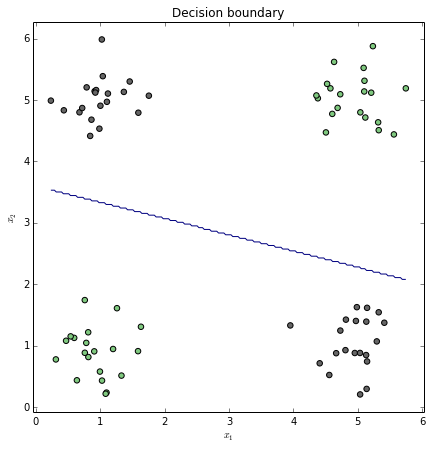

In [22]:
plot_decision_boundary(X, y, clf)

Oh dear...

In [23]:
clf.score(X, y)

0.5

so no better than random

## Using K-means to recover a latent variable


Let's try pre-clustering the data into 4 clusters using K-means, generating a BoW encoding, and then using this for training the classifier. 


In [49]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder


class MyClassifier(object):
    def __init__(self, n_clusters=4):
        self.kmeans = KMeans(n_clusters)
        self.bow_encoder = OneHotEncoder()
        self.clf = LogisticRegression()
        
    def fit(self, X, y):
        self.kmeans.fit(X)
        clusters = self.kmeans.predict(X)
        encoding = self.bow_encoder.fit_transform(clusters.reshape(-1, 1))
        self.clf.fit(encoding, y)
        return self
    
    def encode(self, X):
        c = self.kmeans.predict(X)
        return self.bow_encoder.transform(c.reshape(-1, 1))
    
    def predict(self, X):
        return self.clf.predict(self.encode(X))
    
    def score(self, X, y):
        return self.clf.score(self.encode(X), y)
        
    

In [50]:
clf = MyClassifier(4)
clf.fit(X, y)

In [51]:
print clf.score(X, y)

1.0


Nice one! :D

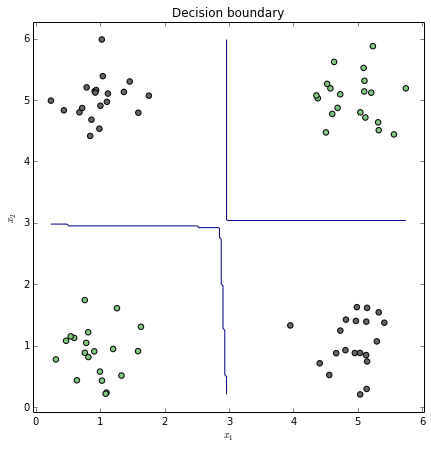

In [52]:
plot_decision_boundary(X, y, clf)

## Note

Here we had labels for all data points. But we can fit a k-means codebook on unlabelled data too, giving a semi-supervised algorithm.